这一节，我们尝试需要一个视频建筑的遥感模型

首先我们先定义一下我们要识别的类型，这次我们要识别的就是建筑(building),我们有darkred颜色表示，其他的作为背景，用lightray表示。影像中的nodata也作为背景。

In [2]:
from rastervision.core.data import ClassConfig

class_config = ClassConfig(
    names=['background', 'building'],
    colors=['lightgray', 'darkred'],
    null_class='background')

/opt/conda/lib/python3.11/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# 数据准备
我们提供了两份数据，一份数据用于训练，一份数据用于推理和计算模型的准确度。

In [3]:
train_image_uri = './data/04.train_model/global_monthly_2018_01_mosaic_L15-0331E-1257N_1327_3160_13.tif'
train_label_uri = './data/04.train_model/global_monthly_2018_01_mosaic_L15-0331E-1257N_1327_3160_13_Buildings.geojson'

val_image_uri = './data/04.train_model/global_monthly_2018_01_mosaic_L15-0357E-1223N_1429_3296_13.tif'
val_label_uri = './data/04.train_model/global_monthly_2018_01_mosaic_L15-0357E-1223N_1429_3296_13_Buildings.geojson'

`raster-vision`提供了`SemanticSegmentationVisualizer`可视化类，可以快速输出我们对影像切片后的效果，已经对应的label数据。我们后面会用到。

In [4]:
from rastervision.pytorch_learner import (
    SemanticSegmentationRandomWindowGeoDataset,
    SemanticSegmentationSlidingWindowGeoDataset,
    SemanticSegmentationVisualizer)

viz = SemanticSegmentationVisualizer(
    class_names=class_config.names, class_colors=class_config.colors)

另外，我们也基于`albumentations`稍微做点数据增强工作，就是对训练数据做旋转、灰度等各种操作，从而可以提高训练集的数量，同时也能提高深度卷积神经网络的性能

In [5]:
import albumentations as A

data_augmentation_transform = A.Compose([
    A.Flip(),
    A.ShiftScaleRotate(),
    A.OneOf([
        A.HueSaturationValue(hue_shift_limit=10),
        A.RGBShift(),
        A.ToGray(),
        A.ToSepia(),
        A.RandomBrightnessContrast(),
        A.RandomGamma(),
    ]),
    A.CoarseDropout(max_height=32, max_width=32, max_holes=5)
])

对于影像，我们要先进行切片，然后进行训练。raster-vision提供两种方式，随机切片和按顺序切片，这里我们采用随机切片`SemanticSegmentationRandomWindowGeoDataset`。      
- `size_lims`, `SemanticSegmentationRandomWindowGeoDataset`将从影像中随机切片指定范围大小的瓦片    
- `max_windows`，切瓦片的数量    
- `out_size`，瓦片的大小，在迭代的时候，会把瓦片缩放到指定大小    

In [6]:
train_ds = SemanticSegmentationRandomWindowGeoDataset.from_uris(
    class_config=class_config,
    image_uri=train_image_uri,
    label_vector_uri=train_label_uri,
    label_vector_default_class_id=class_config.get_class_id('building'),
    size_lims=(150, 200),
    out_size=256,
    max_windows=400,
    transform=data_augmentation_transform,
)
len(train_ds)

400

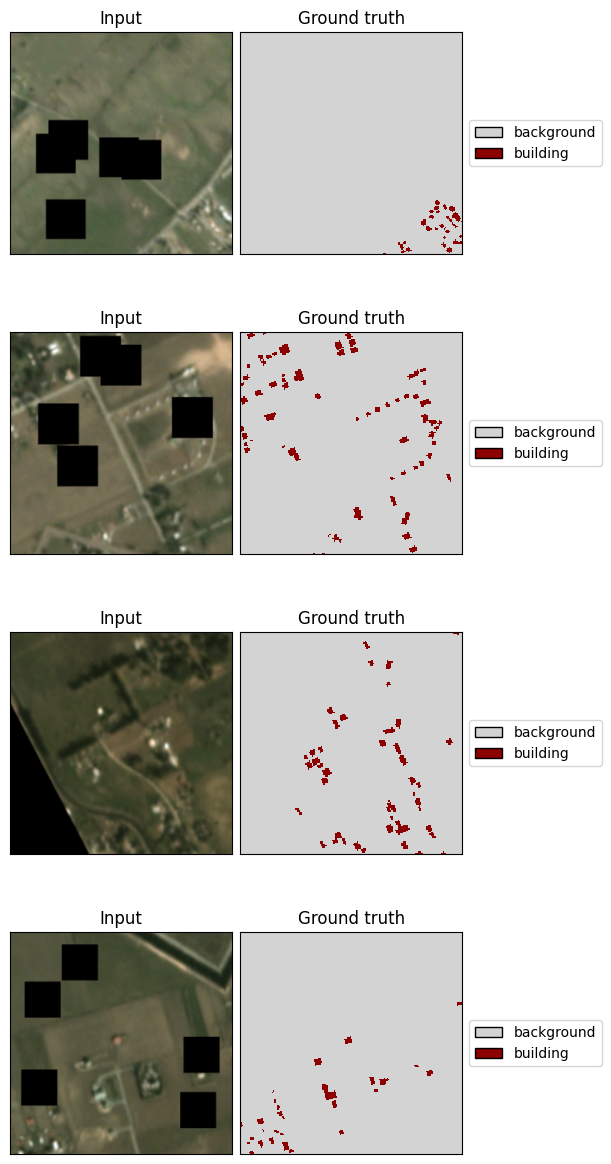

In [7]:
x, y = viz.get_batch(train_ds, 4)
viz.plot_batch(x, y, show=True)

同样，推理的时候，我们也是要先进行切片，然后进行推理，最后合并结果。这里我们采用随机切片`SemanticSegmentationSlidingWindowGeoDataset`。      
`size`, `SemanticSegmentationSlidingWindowGeoDataset`将从影像中切片指定大小的瓦片    
`stride`，瓦片和瓦片之间的间隔      
`out_size`，瓦片的大小，在迭代的时候，会把瓦片缩放到指定大小    

In [8]:
val_ds = SemanticSegmentationSlidingWindowGeoDataset.from_uris(
    class_config=class_config,
    image_uri=val_image_uri,
    label_vector_uri=val_label_uri,
    label_vector_default_class_id=class_config.get_class_id('building'),
    size=200,
    stride=100,
    out_size=256,
)
len(val_ds)

100

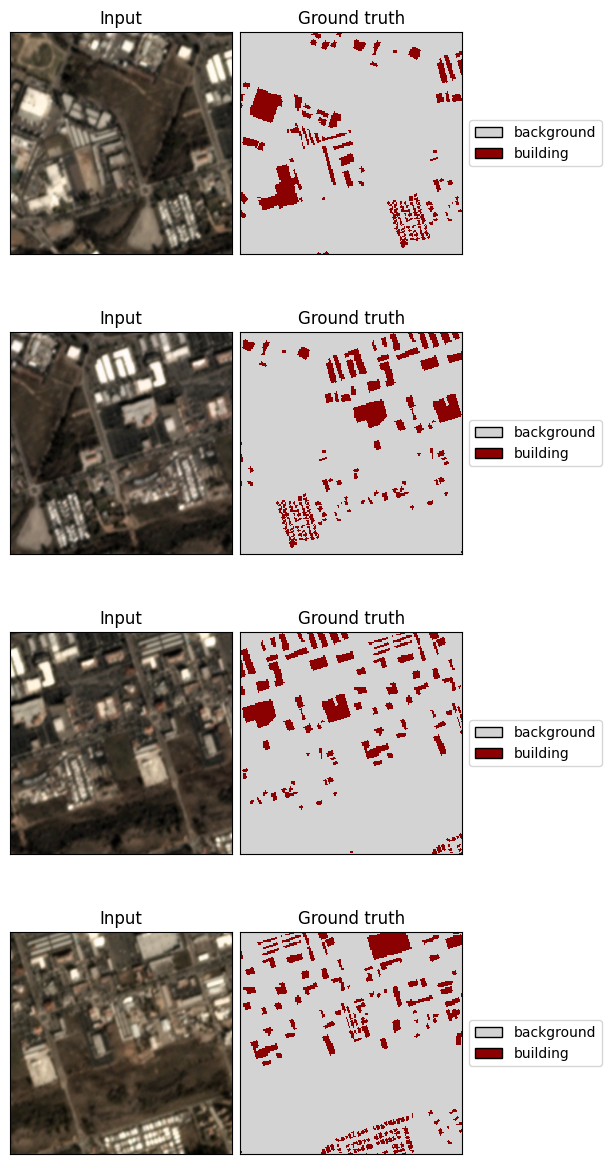

In [9]:
x, y = viz.get_batch(val_ds, 4)
viz.plot_batch(x, y, show=True)

# 模型部署
OK。现在训练数据已经准备好了，接下来我们要开始部署模型了。我们用`pytorch-fpn`这个模型来进行训练。`FPN（Feature Pyramid Network）`是一种用于解决目标检测中多尺度问题的特征金字塔网络，通过融合不同层级的语义信息和空间细节，在目标检测上性能很好。

In [10]:
import torch

model = torch.hub.load(
    'AdeelH/pytorch-fpn:0.3',
    'make_fpn_resnet',
    name='resnet18',
    fpn_type='panoptic',
    num_classes=len(class_config),
    fpn_channels=128,
    in_channels=3,
    out_size=(256, 256),
    pretrained=True)

Using cache found in /root/.cache/torch/hub/AdeelH_pytorch-fpn_0.3


然后，我们来设置些训练的一些参数。    
首先，我们先设置下`learner`。    
- `num_workers`, 用来控制`DataLoader`加载数据时候的进程数量

In [11]:
from rastervision.pytorch_learner import SemanticSegmentationGeoDataConfig
from rastervision.pytorch_learner import SolverConfig
from rastervision.pytorch_learner import SemanticSegmentationLearner
from rastervision.pytorch_learner import SemanticSegmentationLearnerConfig

data_cfg = SemanticSegmentationGeoDataConfig(
    class_config=class_config,
    num_workers=0, 
)
solver_cfg = SolverConfig(
    batch_sz=8,
    lr=3e-2,
    class_loss_weights=[1., 10.]
)
learner_cfg = SemanticSegmentationLearnerConfig(data=data_cfg, solver=solver_cfg)

learner = SemanticSegmentationLearner(
    cfg=learner_cfg,
    output_dir='/tmp/train-demo/',
    model=model,
    train_ds=train_ds,
    valid_ds=val_ds,
)
learner.log_data_stats()

2025-03-20 12:01:09:rastervision.pytorch_learner.learner: INFO - Building dataloaders
2025-03-20 12:01:09:rastervision.pytorch_learner.learner: INFO - Loading checkpoint from /tmp/train-demo/last-model.pth
2025-03-20 12:01:09:rastervision.pytorch_learner.learner: INFO - train_ds: 400 items
2025-03-20 12:01:09:rastervision.pytorch_learner.learner: INFO - valid_ds: 100 items


In [ ]:
%load_ext tensorboard
%tensorboard --bind_all --logdir "/tmp/train-demo/tb-logs" --reload_interval 5

# 模型训练
训练非常简单， 调用`learner`的`train`函数就行了。

In [15]:
learner.train(epochs=5)

2025-03-21 08:28:47:rastervision.pytorch_learner.learner: INFO - Resuming training from epoch 8
2025-03-21 08:28:47:rastervision.pytorch_learner.learner: INFO - train_ds: 400 items
2025-03-21 08:28:47:rastervision.pytorch_learner.learner: INFO - valid_ds: 100 items
2025-03-21 08:28:47:rastervision.pytorch_learner.learner: INFO - Plotting sample training batch.
2025-03-21 08:28:48:rastervision.pytorch_learner.learner: INFO - Plotting sample validation batch.
2025-03-21 08:28:48:rastervision.pytorch_learner.learner: INFO - epoch: 8


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

2025-03-21 08:29:36:rastervision.pytorch_learner.learner: INFO - metrics:
{'epoch': 8,
 'train_loss': 0.20914897322654724,
 'train_time': '0:00:36.565857',
 'val_loss': 0.33587753772735596,
 'avg_precision': 0.9412018656730652,
 'avg_recall': 0.8253695368766785,
 'avg_f1': 0.8794882297515869,
 'background_precision': 0.986091136932373,
 'background_recall': 0.8260362148284912,
 'background_f1': 0.8989953398704529,
 'building_precision': 0.22756421566009521,
 'building_recall': 0.8147710561752319,
 'building_f1': 0.35576409101486206,
 'valid_time': '0:00:11.230200'}
2025-03-21 08:29:36:rastervision.pytorch_learner.learner: INFO - epoch: 9


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

2025-03-21 08:30:14:rastervision.pytorch_learner.learner: INFO - metrics:
{'epoch': 9,
 'train_loss': 0.1987239420413971,
 'train_time': '0:00:33.367212',
 'val_loss': 0.3366689383983612,
 'avg_precision': 0.943107545375824,
 'avg_recall': 0.8245999217033386,
 'avg_f1': 0.8798813223838806,
 'background_precision': 0.987930178642273,
 'background_recall': 0.8236293792724609,
 'background_f1': 0.8983290791511536,
 'building_precision': 0.2305288165807724,
 'building_recall': 0.8400290012359619,
 'building_f1': 0.361775666475296,
 'valid_time': '0:00:04.783783'}
2025-03-21 08:30:14:rastervision.pytorch_learner.learner: INFO - epoch: 10


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

2025-03-21 08:30:52:rastervision.pytorch_learner.learner: INFO - metrics:
{'epoch': 10,
 'train_loss': 0.19742627441883087,
 'train_time': '0:00:33.216304',
 'val_loss': 0.40209975838661194,
 'avg_precision': 0.9349942207336426,
 'avg_recall': 0.8881339430809021,
 'avg_f1': 0.9109618067741394,
 'background_precision': 0.975304365158081,
 'background_recall': 0.9039871692657471,
 'background_f1': 0.9382925629615784,
 'building_precision': 0.2941535711288452,
 'building_recall': 0.636104166507721,
 'building_f1': 0.4022805988788605,
 'valid_time': '0:00:04.621582'}
2025-03-21 08:30:52:rastervision.pytorch_learner.learner: INFO - epoch: 11


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

2025-03-21 08:31:30:rastervision.pytorch_learner.learner: INFO - metrics:
{'epoch': 11,
 'train_loss': 0.20435041189193726,
 'train_time': '0:00:32.978093',
 'val_loss': 0.34110748767852783,
 'avg_precision': 0.9387210607528687,
 'avg_recall': 0.862230658531189,
 'avg_f1': 0.8988514542579651,
 'background_precision': 0.9812395572662354,
 'background_recall': 0.8702022433280945,
 'background_f1': 0.9223912358283997,
 'building_precision': 0.2627736032009125,
 'building_recall': 0.7355010509490967,
 'building_f1': 0.38720858097076416,
 'valid_time': '0:00:04.577482'}
2025-03-21 08:31:30:rastervision.pytorch_learner.learner: INFO - epoch: 12


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

2025-03-21 08:32:08:rastervision.pytorch_learner.learner: INFO - metrics:
{'epoch': 12,
 'train_loss': 0.2055763602256775,
 'train_time': '0:00:33.430251',
 'val_loss': 0.4120340347290039,
 'avg_precision': 0.9347772598266602,
 'avg_recall': 0.8869051933288574,
 'avg_f1': 0.9102122187614441,
 'background_precision': 0.9752528667449951,
 'background_recall': 0.9026973247528076,
 'background_f1': 0.9375734925270081,
 'building_precision': 0.291306734085083,
 'building_recall': 0.6358463168144226,
 'building_f1': 0.3995593190193176,
 'valid_time': '0:00:04.701811'}


可以调用`learner.train(epochs）`在已有的基础上继续训练

In [16]:
learner.train(epochs=1)

2025-03-21 08:32:11:rastervision.pytorch_learner.learner: INFO - Resuming training from epoch 13
2025-03-21 08:32:11:rastervision.pytorch_learner.learner: INFO - train_ds: 400 items
2025-03-21 08:32:11:rastervision.pytorch_learner.learner: INFO - valid_ds: 100 items
2025-03-21 08:32:11:rastervision.pytorch_learner.learner: INFO - Plotting sample training batch.
2025-03-21 08:32:11:rastervision.pytorch_learner.learner: INFO - Plotting sample validation batch.
2025-03-21 08:32:12:rastervision.pytorch_learner.learner: INFO - epoch: 13


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

2025-03-21 08:32:50:rastervision.pytorch_learner.learner: INFO - metrics:
{'epoch': 13,
 'train_loss': 0.20005546510219574,
 'train_time': '0:00:33.592590',
 'val_loss': 0.4050814211368561,
 'avg_precision': 0.9365386366844177,
 'avg_recall': 0.9009979367256165,
 'avg_f1': 0.9184246063232422,
 'background_precision': 0.9749968647956848,
 'background_recall': 0.9183202385902405,
 'background_f1': 0.9458101987838745,
 'building_precision': 0.32513952255249023,
 'building_recall': 0.6256126761436462,
 'building_f1': 0.427895724773407,
 'valid_time': '0:00:04.708112'}


模型训练完成后，我们可以看下验证的效果

2025-03-21 08:49:18:rastervision.pytorch_learner.learner: INFO - Making and plotting sample predictions on the valid set...


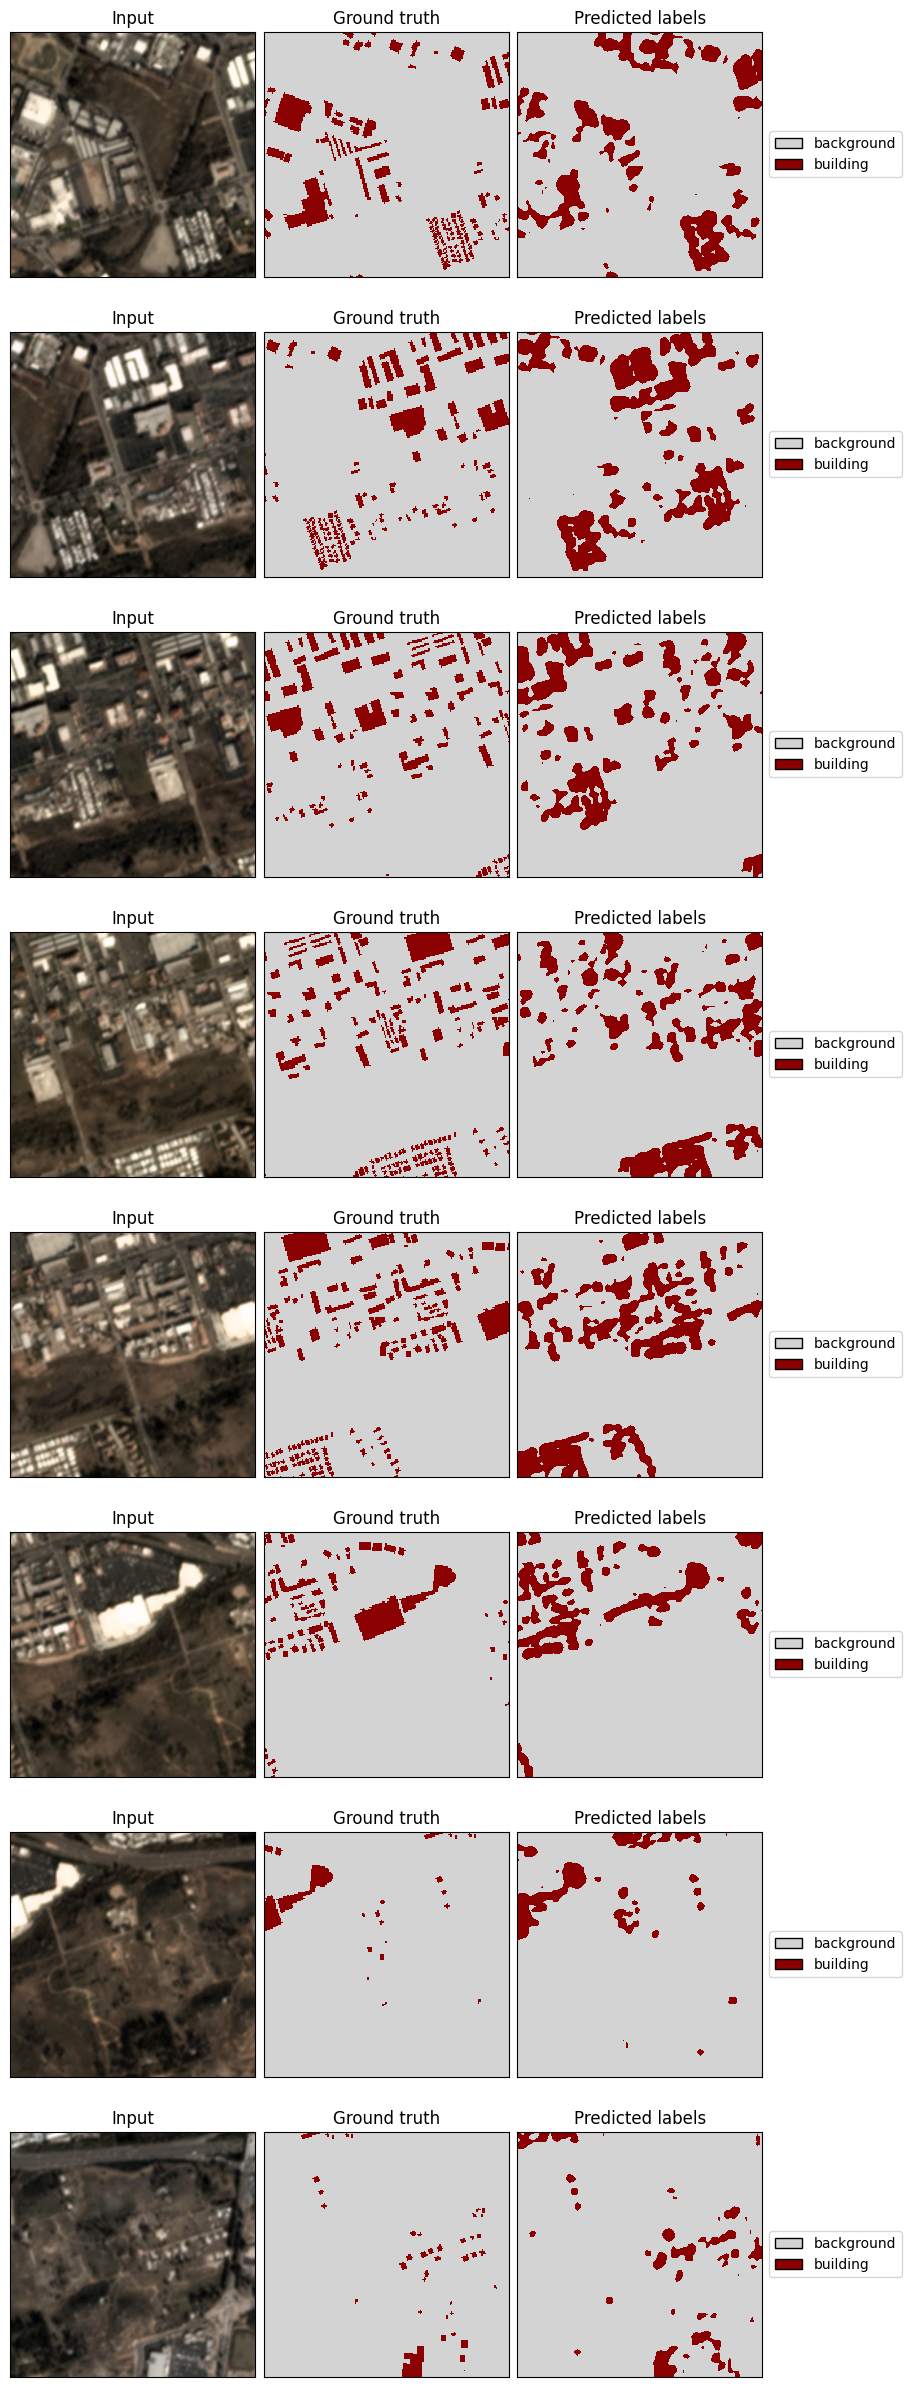

2025-03-21 08:49:20:rastervision.pytorch_learner.learner: INFO - Sample predictions written to /tmp/train-demo/valid_preds.png.


In [17]:
learner.plot_predictions(split='valid', show=True)

# 模型微调
我们可以将模型保存下来，`raster-vision`支持将模型保存为`ONNX`格式，然后我们可以加载这个模型，然后再进行训练微调

In [18]:
learner.save_model_bundle()

2025-03-21 10:16:39:rastervision.pytorch_learner.learner: WARNING - Model was not configured via ModelConfig, and therefore, will not be reconstructable form the model-bundle. You will need to initialize the model yourself and pass it to from_model_bundle().
2025-03-21 10:16:39:rastervision.pytorch_learner.learner: INFO - Creating bundle.
2025-03-21 10:16:40:rastervision.pytorch_learner.learner: INFO - Exporting to model to ONNX.
2025-03-21 10:16:45:rastervision.pytorch_learner.learner: INFO - Saving bundle to /tmp/train-demo/model-bundle.zip.


Zipping: 0it [00:00, ?it/s, model.pth]

In [20]:
from rastervision.pytorch_learner import SemanticSegmentationLearner

learner = SemanticSegmentationLearner.from_model_bundle(
    model_bundle_uri='/tmp/train-demo/model-bundle.zip',
    output_dir='/tmp/train-demo/',
    model=model,
    train_ds=train_ds,
    valid_ds=val_ds,
    training=True,
)

2025-03-21 10:33:46:rastervision.pytorch_learner.learner: INFO - Loading learner from bundle /tmp/train-demo/model-bundle.zip.
2025-03-21 10:33:46:rastervision.pytorch_learner.learner: INFO - Unzipping model-bundle to /opt/data/tmp/tmpuudi74tf/model-bundle
2025-03-21 10:33:47:rastervision.pytorch_learner.learner: INFO - Loading model weights from: /opt/data/tmp/tmpuudi74tf/model-bundle/model.pth
2025-03-21 10:33:47:rastervision.pytorch_learner.learner: INFO - Building dataloaders
2025-03-21 10:33:47:rastervision.pytorch_learner.learner: INFO - Loading checkpoint from /tmp/train-demo/last-model.pth


In [ ]:
learner.train(epochs=1)